- danceability : 춤 추기에 적합한가? 0.0 - 1.0 범위이며 값이 클 수록 춤추기 좋음.
- energy : 말그대로 에너지의 정도라고 받아들이면 될 것 같습니다. 0.0 - 1.0 번위이며 빠르고 화려하고 노이즈가 많은 음악일수록 값이 큽니다.
- instrumentlness : 노래에 보컬이 있는 정도입니다.(0.0 - 1.0)
- liveness : 노래의 라이브 정도를 나타냅니다. 라이브 음원일수록 값이 높겠지요?
- loudness : 소리의 화려함/큼 정도를 보여줍니다.(데시벨 값으로 보여준다고 하네요.)
- mode : major(장조) = 1, minor(단조) = 0 입니다.
- speechiness : 말하는 정도를 보여줍니다. 스포티파이에서는 팟캐스트를 통해 토크쇼나 오디오북 등도 제공하는데 노래와 비교해서 값이 높겠지요?
- tempo : 템포, beats per minute(BPM) 입니다.
- valence : 음원의 밝음 정도를 나타내줍니다. 밝고 행복하고 기쁘면 값이 높고 반대로 슬프고 화나고 우울하면 값이 낮다고 하는데 가장 흥미로운 요소
- key: 말 그대로 목소리 키, 높낮이 이런거 말하는듯...

In [6]:

# Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Tools for analysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")
     

In [7]:
sub = pd.read_csv("sample_submission.csv")
tr = pd.read_csv("train.csv").drop('ID', axis=1)
te = pd.read_csv("test.csv").drop('ID', axis=1)

In [8]:
tr.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,genre
0,0.3341,0.9231,10,0.8540,0.3797,0.0080,0.0002,0.7697,0.7902,0.5391,175,trap
1,0.6344,0.5955,10,0.2826,0.1378,0.0000,0.7137,0.1597,0.4162,0.3043,513,techno
2,0.3983,0.1107,8,0.2459,0.0247,0.7740,0.0000,0.5105,0.4291,0.2324,151,Trap Metal
3,0.3139,0.9702,2,0.9252,0.9590,0.0371,0.3015,0.2539,0.0577,0.5406,246,trap
4,0.0735,0.9452,5,0.7702,0.1397,0.2583,0.0015,0.1774,0.1128,0.3176,229,Dark Trap


In [9]:
tr.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration            0
genre               0
dtype: int64

In [10]:
# Create a correlation matrix
corr_metrics = tr.corr()
corr_metrics.style.background_gradient()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration
danceability,1.000000,-0.344994,-0.011137,-0.243275,0.206565,0.109230,-0.066573,-0.211654,0.370560,-0.196659,-0.050280
energy,-0.344994,1.000000,0.045034,0.583908,-0.161759,-0.485579,0.322109,0.234945,-0.033774,-0.014481,0.298298
key,-0.011137,0.045034,1.000000,-0.007875,-0.031438,-0.007313,0.070276,0.000197,0.027227,-0.015365,0.069347
loudness,-0.243275,0.583908,-0.007875,1.000000,0.056422,-0.251495,-0.186585,0.184924,0.072919,0.194186,-0.109717
speechiness,0.206565,-0.161759,-0.031438,0.056422,1.000000,0.207697,-0.414764,0.068327,0.246963,0.189870,-0.321667
acousticness,0.109230,-0.485579,-0.007313,-0.251495,0.207697,1.000000,-0.312771,-0.114465,0.131303,0.067047,-0.277882
instrumentalness,-0.066573,0.322109,0.070276,-0.186585,-0.414764,-0.312771,1.000000,-0.039586,-0.263131,-0.223367,0.602052
liveness,-0.211654,0.234945,0.000197,0.184924,0.068327,-0.114465,-0.039586,1.000000,-0.020316,0.038450,-0.014935
valence,0.370560,-0.033774,0.027227,0.072919,0.246963,0.131303,-0.263131,-0.020316,1.000000,0.059902,-0.192495
tempo,-0.196659,-0.014481,-0.015365,0.194186,0.189870,0.067047,-0.223367,0.038450,0.059902,1.000000,-0.166175


In [11]:
# Define our features 
features = tr.drop(["genre"], axis=1)

# Define our labels
labels = tr["genre"]

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

In [13]:
print(len(features), len(labels))

25383 25383


# PCA

[0.2436379  0.17868584 0.11458078 0.0911541  0.08377153 0.07374328
 0.06260077 0.05590911 0.0411925  0.03551872 0.01920546]
11


Text(0.5, 0, 'Principal Component #')

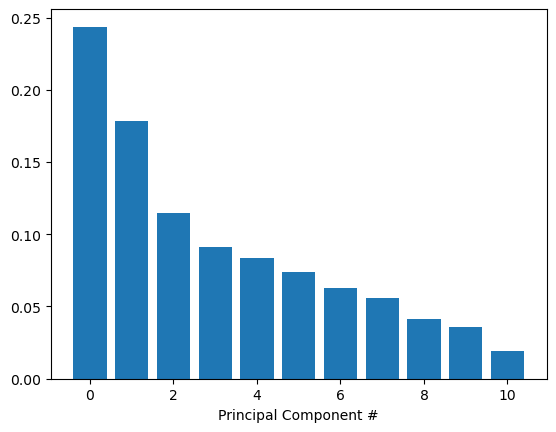

In [14]:
# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

print(pca.explained_variance_ratio_)
print(pca.n_components_)

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(11), exp_variance)
ax.set_xlabel('Principal Component #')

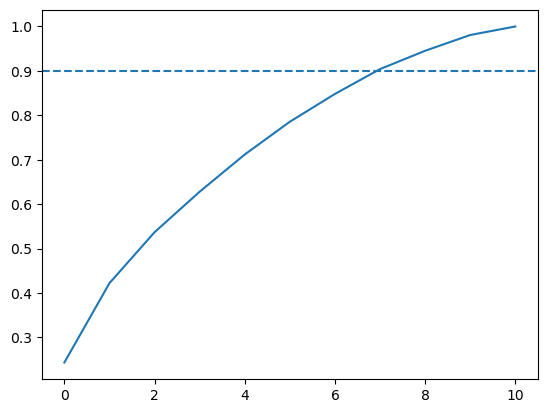

In [16]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(range(11), cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [17]:
# Function used for cross validation.
def cross_val(clf, K, metadata, label, title, return_clf = False):
    # scores is used to give average of accuracy
    scores = []
    cv = KFold(n_splits=K)
    
    # K fold analysis, used for spliting the data into k batches
    for train_index, test_index in cv.split(metadata):
      
        X_train, y_train = metadata[train_index], label[train_index]
        X_test, y_test = metadata[test_index], label[test_index]

        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    
    # Display the average score
    print(title + " Cross-Validation Accuracy Score: ", round(np.mean(scores), 2))
    
    # returns the classifier if needed
    if(return_clf == True):
        return clf

# Function used for parameter tuning.
def parameter_tuning(clf, metadata, label, param_grid):
  # Initialising grid search
  grid = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      scoring='accuracy',
                      verbose=2,
                      cv = 2,
                      n_jobs=-1
                      )
  
  # Inputing the data onto the grid search
  grid_result = grid.fit(metadata, label)

  # Displaying the best score with its corrsponding parameters
  print('Best Score: ', grid_result.best_score_)
  print('Best Params: ', grid_result.best_params_)

# Function used for displaying confusion matrix.
def display_confusionMatrix(clf, X, y, title):
  cm = confusion_matrix(y, clf.predict(X), labels=clf.classes_)
  normed_c = (cm.T / cm.astype(np.float).sum(axis=1)).T
  disp = ConfusionMatrixDisplay(confusion_matrix=normed_c,
                                display_labels=clf.classes_)
  disp.plot(
      cmap=plt.cm.Blues
      )
  disp.ax_.set_title(title + " Confusion Matrix:")

In [18]:
# Different types of classifiers. 
#------------------------------------------------------------------------------#
# Classifier Random Forest
classifier_rf = RandomForestClassifier()
title_rf = "Random Forest"

#------------------------------------------------------------------------------#
# Classifier Decision Tree
classifier_dt = DecisionTreeClassifier()
title_dt = "Decision Tree"

#------------------------------------------------------------------------------#
# Classifier Support Vector Machine with Kernal as 'rbf' (SVC)
classifier_svc = SVC(max_iter=-1)
title_svc = "Support Vector Machine"

#------------------------------------------------------------------------------#
# Classifier K-Nearest Neighbors (KN)
classifier_kn = KNeighborsClassifier(70)
title_kn = "K-Nearest Neighbors"

#------------------------------------------------------------------------------#
# Classifier Naive Bayes (NB)
classifier_nb = GaussianNB()
title_nb = "Naive Bayes"

#------------------------------------------------------------------------------#
# Classifier Multi-Layer-Perceptron (MLP)
classifier_mlp = MLPClassifier(
    hidden_layer_sizes=100
    , activation="logistic"
    , solver="sgd"
    , max_iter=1000
    )
title_mlp = "Multi-Layer-Perceptron"

#------------------------------------------------------------------------------#
# List of classifiers
classifiers = [
               classifier_dt
               , classifier_kn
               , classifier_mlp
               , classifier_nb
               , classifier_rf
               , classifier_svc
]

# List of titles
titles = [
          title_dt
          , title_kn
          , title_mlp
          , title_nb
          , title_rf
          , title_svc
]
     

<Figure size 640x480 with 0 Axes>

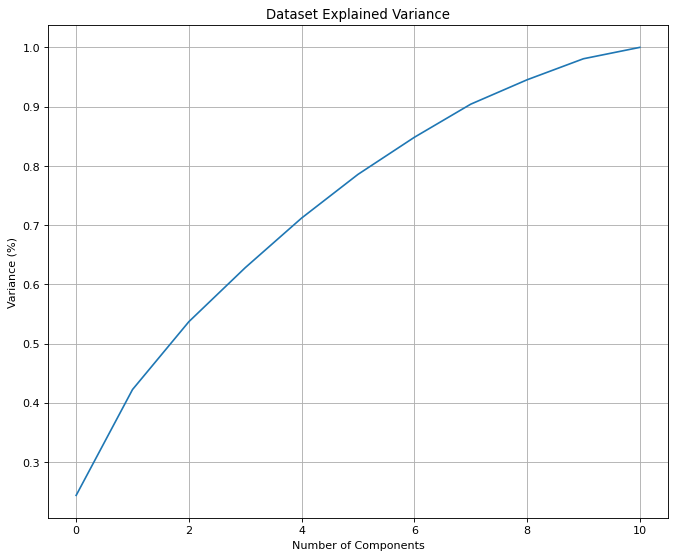

In [19]:

#Fitting the PCA algorithm with the Data
pca = PCA().fit(scaled_train_features)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.grid()
plt.show()

In [20]:

# Using 70 number of components for dataset
# which is indicated from the above graph.

# Fitting the standardised data with 70 number of components
pca = PCA(n_components = 10)
pca_metadata = pca.fit_transform(scaled_train_features)

In [21]:
# Splitting the reduced dataset using pca
# into training and testing dataset.
X_train, X_test, y_train, y_test = train_test_split(
      pca_metadata 
      , labels
      , test_size=0.3
      , random_state=42
      , shuffle=True
      )

In [22]:
# Fitting training data on-to the classifiers
for clf, title in zip(classifiers, titles):
  clf.fit(X_train, y_train)
  print(title + " Accuracy Score:", round(clf.score(X_test, y_test), 2))

Decision Tree Accuracy Score: 0.47
K-Nearest Neighbors Accuracy Score: 0.57
Multi-Layer-Perceptron Accuracy Score: 0.62
Naive Bayes Accuracy Score: 0.53
Random Forest Accuracy Score: 0.59
Support Vector Machine Accuracy Score: 0.64


In [23]:
# Fitting data on-to the classifiers using cross-validation
for clf, title in zip(classifiers, titles):
  cross_val(clf, 5, pca_metadata, labels, title, return_clf = False)

Decision Tree Cross-Validation Accuracy Score:  0.48
K-Nearest Neighbors Cross-Validation Accuracy Score:  0.57
Multi-Layer-Perceptron Cross-Validation Accuracy Score:  0.62
Naive Bayes Cross-Validation Accuracy Score:  0.52
Random Forest Cross-Validation Accuracy Score:  0.59
Support Vector Machine Cross-Validation Accuracy Score:  0.64


In [24]:
# Classification reports of the best classifiers

# MLP
print(title_mlp + " Classification Report:")
print(classification_report(y_test, classifier_mlp.predict(X_test)))

# SVC
print(title_svc + " Classification Report:")
print(classification_report(y_test, classifier_svc.predict(X_test)))

Multi-Layer-Perceptron Classification Report:
                 precision    recall  f1-score   support

      Dark Trap       0.49      0.40      0.44       782
            Emo       0.51      0.46      0.48       284
         Hiphop       0.47      0.37      0.41       530
            Pop       1.00      0.01      0.03        67
            Rap       0.49      0.35      0.41       356
            RnB       0.37      0.33      0.35       390
     Trap Metal       0.45      0.26      0.33       399
Underground Rap       0.44      0.62      0.51      1060
            dnb       0.83      0.92      0.87       519
      hardstyle       0.71      0.79      0.75       508
      psytrance       0.87      0.90      0.88       544
      techhouse       0.77      0.82      0.79       535
         techno       0.81      0.86      0.83       535
         trance       0.69      0.74      0.71       549
           trap       0.74      0.72      0.73       557

       accuracy                         

In [26]:
te.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration
0,0.8861,0.6821,2,0.7241,0.3103,0.1451,0.0000,0.5087,0.8863,0.9648,279
1,0.8495,0.3883,1,0.4495,0.4661,0.6234,0.0004,0.1347,0.4062,0.9051,151
2,0.2479,0.7549,3,0.7683,0.3131,0.5718,0.0000,0.1250,0.6357,0.3234,196
3,0.6344,0.9804,1,0.6599,0.0931,0.0020,0.6016,0.8799,0.8790,0.2946,207
4,0.6237,0.6926,6,0.6716,0.0269,0.0283,0.0001,0.1580,0.9288,0.3642,196


In [27]:
features

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration
0,0.3341,0.9231,10,0.8540,0.3797,0.0080,0.0002,0.7697,0.7902,0.5391,175
1,0.6344,0.5955,10,0.2826,0.1378,0.0000,0.7137,0.1597,0.4162,0.3043,513
2,0.3983,0.1107,8,0.2459,0.0247,0.7740,0.0000,0.5105,0.4291,0.2324,151
3,0.3139,0.9702,2,0.9252,0.9590,0.0371,0.3015,0.2539,0.0577,0.5406,246
4,0.0735,0.9452,5,0.7702,0.1397,0.2583,0.0015,0.1774,0.1128,0.3176,229
...,...,...,...,...,...,...,...,...,...,...,...
25378,0.8814,0.3398,6,0.4602,0.3825,0.4505,0.0000,0.4222,0.8753,0.4081,88
25379,0.7505,0.5657,0,0.6682,0.1038,0.1281,0.0000,0.0596,0.9583,0.4273,123
25380,0.2520,0.7617,8,0.4928,0.0410,0.0003,0.8395,0.0843,0.1372,0.7828,353
25381,0.6202,0.3455,0,0.6499,0.7960,0.4818,0.0000,0.2007,0.0194,0.9756,120


In [28]:
# Define our features 
features1 = te

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features1 = scaler.fit_transform(features1)

In [29]:
pca = PCA(n_components = 10)
pca_metadata1 = pca.fit_transform(scaled_train_features1)

In [30]:
pred = classifier_svc.predict(pca_metadata1)

In [31]:
#ID,genre
d={'ID':sub['ID'],'genre':pred}
ans=pd.DataFrame(d)
ans.to_csv('sample_submission.csv',index=False) # saving to a csv file for predictions on kaggle.